In [1]:
import os
os.chdir('../..')

In [2]:
import numpy as np
import torch
from utils import util_modulation as umod
from collections import OrderedDict
from tqdm import tqdm


np.random.seed(777)

torch.manual_seed(777)
# %load_ext autoreload
# %autoreload 2

In [3]:
from models.modulator_models.MAMLNeural import MAMLNeural
from models.modulator_models.Neural import Neural
# from models.maml_modulator import MAMLModulatorGradientPassing
from models.demodulator import Demodulator
from models.demodulator_models.Classic import Classic as ClassicDemod
from utils.util_data import torch_tensor_to_numpy as to_numpy
from utils.util_data import  numpy_to_torch_tensor as to_tensor
from utils.util_data import integers_to_symbols, symbols_to_integers

In [4]:
kwargs = {'verbose': True}
bps = 6

In [5]:
pg = Neural(bits_per_symbol=bps, hidden_layers=[20])
maml = MAMLNeural(bits_per_symbol=bps, hidden_layers=[20])
# mm = MAMLModulator(model=MAMLNeural, restrict_energy = 2, bits_per_symbol=bps, optimizer='sgd', hidden_layers=[20], **kwargs)

In [6]:
ntasks = 8
demods = [Demodulator(model=ClassicDemod, bits_per_symbol=bps, rotation=rot, **kwargs)
        for rot in np.random.uniform(0, 2*np.pi, ntasks)]

Demodulator classic initialized WITHOUT an optimizer
Demodulator classic initialized WITHOUT an optimizer
Demodulator classic initialized WITHOUT an optimizer
Demodulator classic initialized WITHOUT an optimizer
Demodulator classic initialized WITHOUT an optimizer
Demodulator classic initialized WITHOUT an optimizer
Demodulator classic initialized WITHOUT an optimizer
Demodulator classic initialized WITHOUT an optimizer


In [7]:
import matplotlib.pyplot as plt
%matplotlib inline
def visualize_constellation(data_c, labels, legends = True):
    for label in np.unique(labels):
        cur_data_c = data_c[labels==label,:]
        plt.scatter(cur_data_c[:,0], cur_data_c[:,1], label = label)
    if legends:
        plt.legend()
    plt.show()
    
def plot_constellation(mod, params=None):
    data_si = np.arange(2**mod.bits_per_symbol)
    data_sb =  to_tensor(integers_to_symbols(data_si, mm.bits_per_symbol)).float()
    data_c = mod.model.forward(data_sb, params)
    
    data_c = to_numpy(data_c)
    for label in np.unique(data_si):
        cur_data_c = data_c[data_si==label,:]
        plt.scatter(cur_data_c[:,0], cur_data_c[:,1], label = label)

        plt.annotate(label, (cur_data_c[:,0], cur_data_c[:,1]))
        
    plt.show()

In [8]:
import torch
# print(torch.__version__) 
import torch.nn as nn
import numpy as np
from tqdm import tqdm
from torch.distributions.normal import Normal
from models.modulator import Modulator
from utils.util_meta import update_parameters
from utils.util_data import integers_to_symbols, symbols_to_integers, add_cartesian_awgn_tensor
from utils.util_data import torch_tensor_to_numpy as to_numpy
from utils.util_data import  numpy_to_torch_tensor as to_tensor


class MAMLModulatorLossPassing(Modulator):
    def __init__(self,*,
                 stepsize_meta:float = 1e-3,
                 stepsize_inner:float = 1e-1,
                 first_order:bool = True,
                 inner_steps:int = 10,
                 inner_batch_size:int = 16,
                 outer_batch_size:int = 32,
                 SNR_db = 10,
                 std_explore = 1e-3,
                 lambda_prob =0,
                 **kwargs
                 ):
        """
        For the MAML Demodulator, the `optimizer` only defines the optimizer
        for the outer meta-learning loop. The inner fast adaptation loop
        is hand-written SGD because PyTorch does not support differentiation
        through parameter updates.
        """
        super(MAMLModulatorLossPassing, self).__init__(**kwargs)
        self.stepsize_meta = torch.tensor(stepsize_meta)
        self.stepsize_inner = torch.tensor(stepsize_inner)
        self.first_order = first_order
        self.inner_steps = inner_steps
        self.inner_batch_size = inner_batch_size
        self.outer_batch_size = outer_batch_size
        self.SNR_db = SNR_db
        self.std_explore= std_explore
        self.lambda_prob = lambda_prob
        self.verbose = False
        if 'verbose' in kwargs:
            self.verbose = kwargs['verbose']


        # Override the base class's optimizer with meta-params and meta-lr
        optimizers = {
            'adam': torch.optim.Adam,
            'sgd': torch.optim.SGD,
        }
        if kwargs['optimizer'] and hasattr(self.model, 'named_parameters') and not hasattr(self.model, "update"):
            optimizer = optimizers[kwargs['optimizer'].lower()]
            self.param_dicts = [
                {'params': self.model.meta_parameters().values(), 'lr': stepsize_meta},
            ]
            self.optimizer = optimizer(self.param_dicts, lr=stepsize_meta)
    def update_maml(self, demods):
        model = self.model
        ntasks = len(demods)
        self.optimizer.zero_grad()
        outer_loss = torch.tensor(0.)
        outer_ber = 0.
        # Calculate inner losses and take fast steps
#         with tqdm(range(ntasks), desc="Task", total=ntasks, disable=not self.verbose) as pbar:

        for it in range(ntasks):
            demod = demods[it]
#             for demod in demods:
            #Generate random symbols to modulate
            meta_loss, inner_loss, meta_ber = self._update_inner(model, demod)

            outer_loss += meta_loss
            outer_ber += meta_ber

            if self.verbose:
                print("meta_ber:" ,meta_ber, "meta loss:", meta_loss.detach().cpu().numpy(), "inner_loss:", inner_loss)
#                 pbar.set_postfix({"meta_ber": meta_ber, "meta loss": meta_loss.detach().cpu().numpy(), "inner_loss": inner_loss})
            # Gradient update on mean task meta-loss
        outer_loss /= ntasks
        outer_ber /= ntasks
        outer_loss.backward()
#         params =model.meta_parameters()
#         for param in params:
#             print(param, params[param].grad)
        
#         print("Outer loss", outer_loss)
        
    #TODO THis seems to be the problem line
#         params = model.meta_parameters()
        
#         for param in params:
#             print(param)
#             print(params[param].grad)
#             plt.plot(to_numpy(params[param].grad).T, 'o-')
#             plt.show()
#             torch.nn.utils.clip_grad_norm(params[param],100)
        self.optimizer.step()
        return outer_loss.detach().cpu().numpy(), outer_ber
    def update_test(self, demod, nshots, batch_size = 32, step_size=1e-2):
        model = self.model
        l1, l2 = [self.lambda_l1, self.lambda_l2]
#         criterion = nn.CrossEntropyLoss(reduction='mean')
        bers = []
        params =model.meta_parameters()
        for i in range(nshots):
            data_si = np.random.randint(0, 2**self.bits_per_symbol, size = [batch_size])
            data_sb = to_tensor(integers_to_symbols(data_si, self.bits_per_symbol)).float()
            means = model.forward(data_sb, params=params)
#             print(means.shape)

#             visualize_constellation(to_numpy(means), data_si)
            policy = Normal(means, self.std_explore)
            data_c = policy.sample()
            
#             visualize_constellation(to_numpy(data_c), data_si)

            log_probs =  torch.log(policy.log_prob(data_c).exp() + self.lambda_prob).sum(dim = 1)
            
            data_c_noisy = add_cartesian_awgn_tensor(data_c, SNR_db=self.SNR_db)
            

        
            labels_sb_g = demod.demodulate(to_numpy(data_c_noisy))
            bit_loss = np.sum(np.abs(labels_sb_g - to_numpy(data_sb)), 1)
            reward = -bit_loss
            baseline_reward = -1
            
            loss =  -torch.mean(log_probs * to_tensor(reward -  baseline_reward))
#             print(loss)

            if l1 > 0:
                loss += l1 * model.l1_loss(params.values())
            if l2 > 0:
                loss += l2 * model.l2_loss(params.values())
                
                
            data_c_noisy = add_cartesian_awgn_tensor(data_c, SNR_db=self.SNR_db)
            
            logits = demod.demodulate_tensor_grad(data_c_noisy)
            labels_sb_g = demod.demodulate(to_numpy(data_c_noisy))
#             ber = np.mean(np.mean(np.abs(labels_sb_g - to_numpy(data_sb)), 1), 0)
#             bers.append(ber)
#             loss =criterion(logits, to_tensor(data_si).view([-1]).long())
#             if l1 > 0:
#                 loss += l1 * model.l1_loss(params.values())
#             if l2 > 0:
#                 loss += l2 * model.l2_loss(params.values())
            # Update params: performs one SGD step
            model.zero_grad()
            params = update_parameters(model, loss, params=params, 
                                       step_size=step_size,
                                       first_order=True)
            
           
            inner_loss = loss.detach().cpu().numpy()
            
            with torch.no_grad():
                data_si = np.random.randint(0, 2**self.bits_per_symbol, size = [batch_size])
                data_sb = to_tensor(integers_to_symbols(data_si, self.bits_per_symbol)).float().to(self.device)
                data_c = model.forward(data_sb, params=params)
                data_c_noisy = add_cartesian_awgn_tensor(data_c, SNR_db=self.SNR_db)

                labels_sb_g = demod.demodulate(to_numpy(data_c_noisy))
                bit_loss = np.sum(np.abs(labels_sb_g - to_numpy(data_sb)), 1)
                bers.append(np.mean(bit_loss) / self.bits_per_symbol)
        
            #For plotting
        plot_constellation(self, params)
        return bers
   
        
    def _update_inner(self, model, demod):
        params = model.meta_parameters()
        l1, l2 = [self.lambda_l1, self.lambda_l2]
        criterion = nn.CrossEntropyLoss(reduction='mean')
        inner_loss = 0.
       
        for ib in range(self.inner_steps):
            data_si = np.random.randint(0, 2**self.bits_per_symbol, size = [self.inner_batch_size])
            data_sb = to_tensor(integers_to_symbols(data_si, self.bits_per_symbol)).float()
            means = model.forward(data_sb, params=params)
            policy = Normal(means, self.std_explore)
            data_c = policy.sample()
            log_probs =  torch.log(policy.log_prob(data_c).exp() + self.lambda_prob).sum(dim = 1)
#             plt.plot(to_numpy(log_probs))
#             plt.show()

            data_c_noisy = add_cartesian_awgn_tensor(data_c, SNR_db=self.SNR_db)
            

        
            labels_sb_g = demod.demodulate(to_numpy(data_c_noisy))
            bit_loss = np.sum(np.abs(labels_sb_g - to_numpy(data_sb)), 1)
            reward = -bit_loss
            baseline_reward = 0
            
            loss =  -torch.mean(log_probs * to_tensor(reward -  baseline_reward))
            

            if l1 > 0:
                loss += l1 * model.l1_loss(params.values())
            if l2 > 0:
                loss += l2 * model.l2_loss(params.values())
            # Update params: performs one SGD step
            model.zero_grad()
            params = update_parameters(model, loss, params=params, 
                                       step_size=self.stepsize_inner,
                                       first_order=self.first_order)
            
            
            inner_loss = loss.detach().cpu().numpy()
#             print(ib, inner_loss)
              # Calculate meta-loss for this task
        meta_data_si  = np.random.randint(0, 2**self.bits_per_symbol, size = [self.outer_batch_size])
        meta_data_sb = to_tensor(integers_to_symbols(meta_data_si, self.bits_per_symbol)).float()
        meta_means = model.forward(meta_data_sb, params=params)
        policy = Normal(meta_means, self.std_explore)
        meta_data_c = policy.sample()
#         meta_log_probs = policy.log_prob(meta_data_c).sum(dim=1)

        meta_log_probs = torch.log(policy.log_prob(meta_data_c).exp() + self.lambda_prob).sum(dim = 1)
    
#         plt.plot(to_numpy(meta_log_probs))
#         plt.show()
#         print(meta_log_probs)
        meta_data_c_noisy = add_cartesian_awgn_tensor(meta_data_c, SNR_db=self.SNR_db)
#         meta_logits = demod.demodulate_tensor_grad(meta_data_c_noisy)
#         meta_loss =criterion(meta_logits, to_tensor(meta_data_si).view([-1]).long())
        if self.verbose:
            visualize_constellation(to_numpy(meta_data_c), meta_data_si, legends = False)
        
        meta_labels_sb_g = demod.demodulate(to_numpy(meta_data_c_noisy))
        
#    
     
        meta_bit_loss = np.sum(np.abs(meta_labels_sb_g - to_numpy(meta_data_sb)), 1)
        meta_reward = -meta_bit_loss
        
#         print(meta_reward)
        
        meta_baseline_reward = 0
        
    
        meta_loss =  -torch.mean(meta_log_probs * to_tensor(meta_reward -  meta_baseline_reward))
            
            
            
        if l1 > 0:
            meta_loss += l1 * model.l1_loss(params.values)
        if l2 > 0:
            meta_loss += l2 * model.l2_loss(params.values)
        
#         print("Meta loss", meta_loss)
        
#         params = update_parameters(model, meta_loss, params=params, 
#                                        step_size=self.stepsize_meta,
#                                        first_order=self.first_order)
            
            
        #For ber calculations
        with torch.no_grad():
            meta_data_c_ber = meta_means        
            meta_data_c_noisy_ber = add_cartesian_awgn_tensor(meta_data_c_ber, SNR_db=self.SNR_db)
            meta_labels_sb_g_ber = demod.demodulate(to_numpy(meta_data_c_noisy_ber))
            meta_ber = np.mean(np.mean(np.abs(meta_labels_sb_g_ber - to_numpy(meta_data_sb)), 1), 0)

        
        
        return meta_loss, inner_loss, meta_ber
            
            
#         #Sample random symbols
#        
#         
#         criterion = nn.CrossEntropyLoss(reduction = 'mean')
        
#         
#         print(loss)
#         loss.backward()

       

#         plot_boundary(md)
#         mm.verbose = True
#     signal_batches = np.stack([channel(symbs, 10) for symbs in tasks])
#     meta_signal_batches = np.stack([channel(symbs, 10) for symbs in tasks])    
#     loss = md.update_maml(signal_batches, truth_batches, meta_signal_batches, truth_batches)
#     losses.append(loss)
#     md.verbose = False
        
# mm = MAMLModulatorLossPassing(model=MAMLNeural, SNR_db = 15, stepsize_meta =5e-1, \
#                    outer_batch_size = 256, restrict_energy = 2, inner_steps = 1,\
#                    inner_batch_size= 128, stepsize_inner = 2e-1, \
#                    bits_per_symbol=bps, optimizer='sgd', hidden_layers=[50],  std_explore = 1e-1, **kwargs)
# # epochs = 50
# mm.update_maml(demods)

Epoch:   0%|          | 0/500 [00:00<?, ?it/s]

Modulator neural initialized with SGD optimizer.
Epoch 0


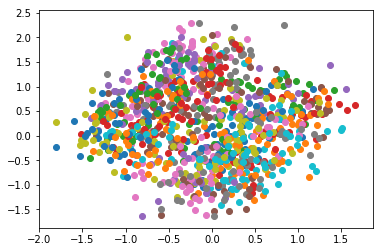

meta_ber: 0.24576822916666669 meta loss: -1.2382294 inner_loss: -0.92394996


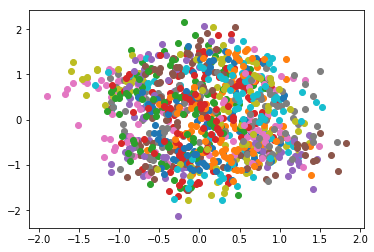

meta_ber: 0.3209635416666667 meta loss: -0.93278134 inner_loss: -1.0128351


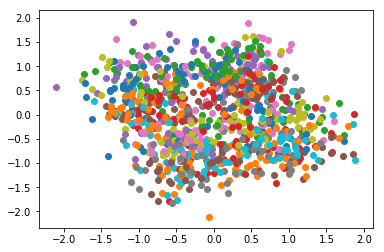

meta_ber: 0.3155924479166667 meta loss: -0.9454982 inner_loss: -1.1803303


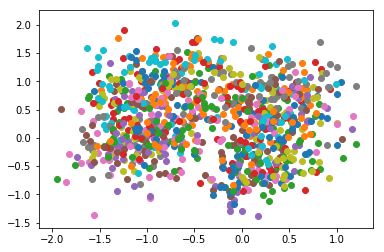

meta_ber: 0.3346354166666667 meta loss: -1.0746139 inner_loss: -1.0980496


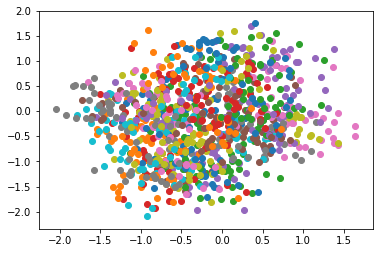

meta_ber: 0.3992513020833333 meta loss: -0.8814793 inner_loss: -1.1789912


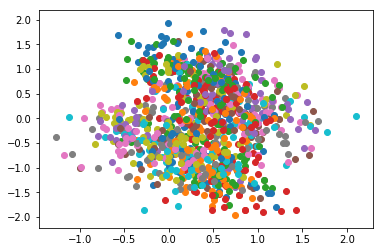

meta_ber: 0.3447265625 meta loss: -1.1291537 inner_loss: -1.0605588


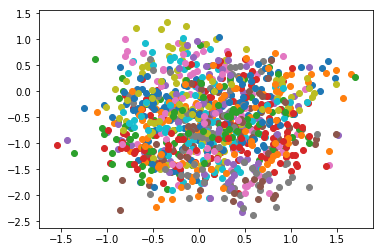

meta_ber: 0.3359375 meta loss: -1.1218687 inner_loss: -1.0976382


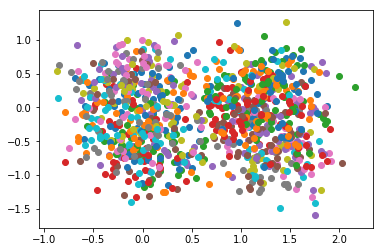

Epoch:   0%|          | 1/500 [00:03<25:22,  3.05s/it, Loss=-1.0566714, BER=0.329]

meta_ber: 0.3347981770833333 meta loss: -1.1297469 inner_loss: -1.0296737


Epoch:  20%|██        | 100/500 [00:51<03:27,  1.93it/s, Loss=-1.1505818, BER=0.236]

Epoch 100


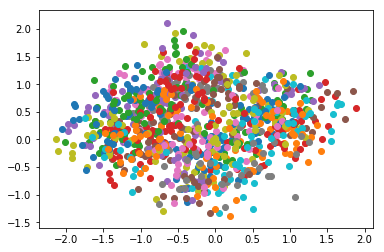

meta_ber: 0.234375 meta loss: -1.1478318 inner_loss: -1.2238919


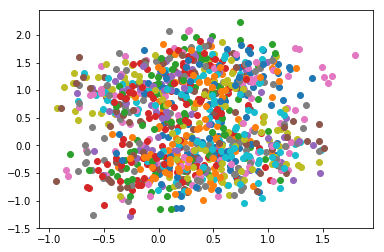

meta_ber: 0.30582682291666663 meta loss: -1.1772174 inner_loss: -1.1397331


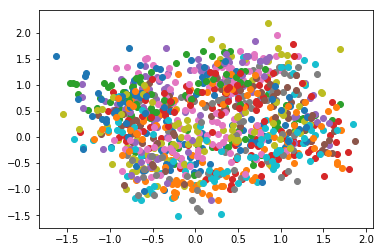

meta_ber: 0.185546875 meta loss: -1.0779415 inner_loss: -1.1665002


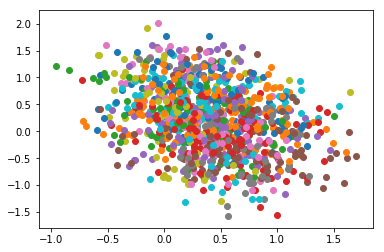

meta_ber: 0.36002604166666663 meta loss: -1.2332766 inner_loss: -1.2391336


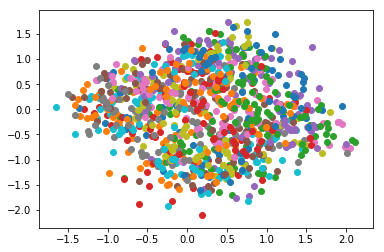

meta_ber: 0.21842447916666666 meta loss: -1.089433 inner_loss: -1.1479403


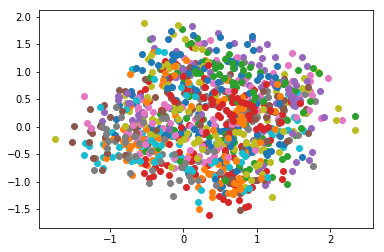

meta_ber: 0.18733723958333331 meta loss: -1.2592729 inner_loss: -1.1666182


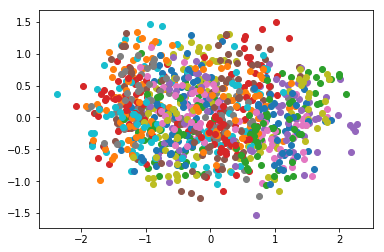

meta_ber: 0.369140625 meta loss: -0.9369998 inner_loss: -1.1180874


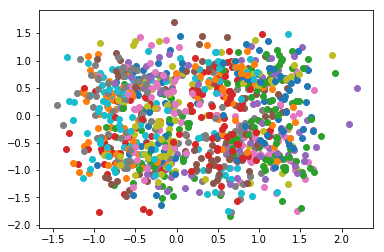

Epoch:  20%|██        | 101/500 [00:54<03:36,  1.84it/s, Loss=-1.1338413, BER=0.259]

meta_ber: 0.21175130208333331 meta loss: -1.148757 inner_loss: -1.0640162


Epoch:  40%|████      | 200/500 [01:43<02:35,  1.93it/s, Loss=-1.1884823, BER=0.188]

Epoch 200


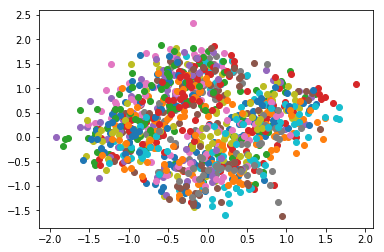

meta_ber: 0.16585286458333331 meta loss: -1.1434848 inner_loss: -1.1667373


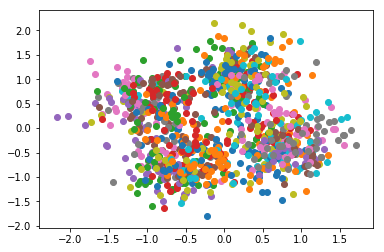

meta_ber: 0.24495442708333331 meta loss: -0.9774715 inner_loss: -1.2338305


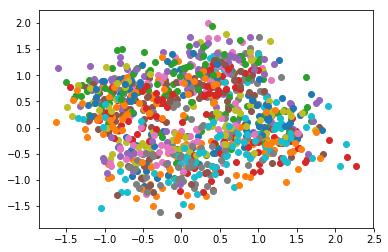

meta_ber: 0.16569010416666666 meta loss: -1.1598003 inner_loss: -1.287523


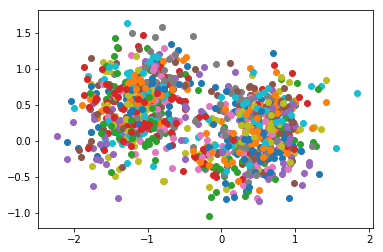

meta_ber: 0.3435872395833333 meta loss: -1.0320356 inner_loss: -1.2330306


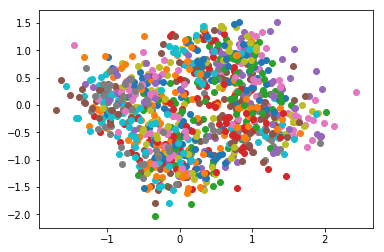

meta_ber: 0.17805989583333331 meta loss: -1.1982634 inner_loss: -1.2513088


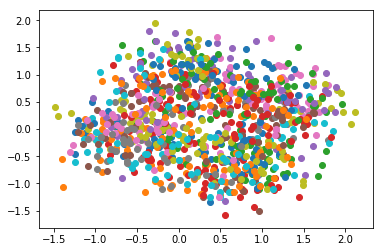

meta_ber: 0.15755208333333331 meta loss: -1.1032772 inner_loss: -1.1694206


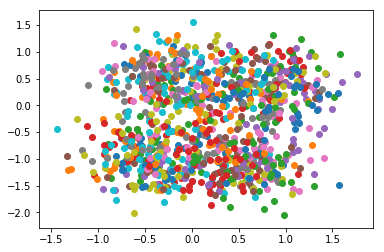

meta_ber: 0.19466145833333331 meta loss: -1.0601012 inner_loss: -1.0676359


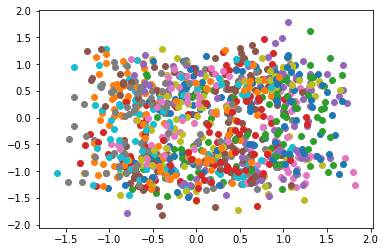

Epoch:  40%|████      | 201/500 [01:46<02:38,  1.89it/s, Loss=-1.0962715, BER=0.206]

meta_ber: 0.19954427083333334 meta loss: -1.0957378 inner_loss: -1.2686709


Epoch:  60%|██████    | 300/500 [02:39<01:46,  1.89it/s, Loss=-1.1109383, BER=0.201]

Epoch 300


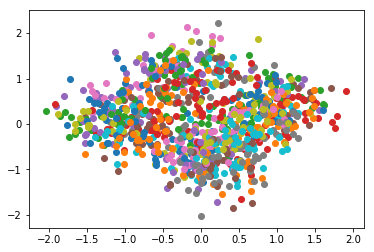

meta_ber: 0.22965494791666666 meta loss: -1.0638489 inner_loss: -1.1782727


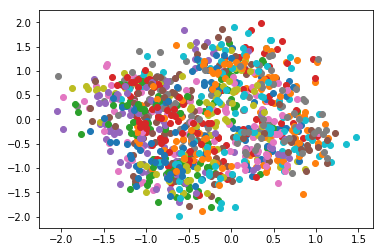

meta_ber: 0.20751953125 meta loss: -1.0869905 inner_loss: -1.0645263


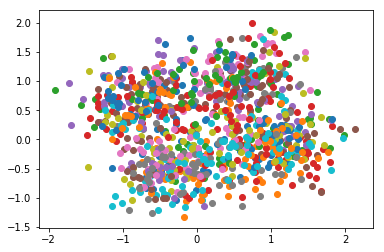

meta_ber: 0.17610677083333334 meta loss: -1.1982183 inner_loss: -1.0816463


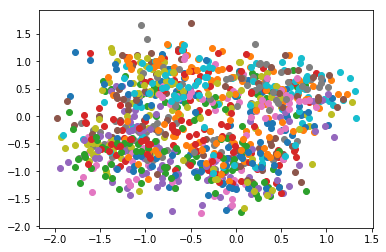

meta_ber: 0.18538411458333331 meta loss: -1.1682694 inner_loss: -1.0318701


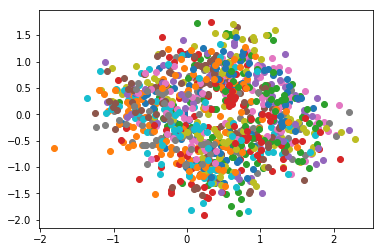

meta_ber: 0.17545572916666666 meta loss: -1.105447 inner_loss: -1.1105362


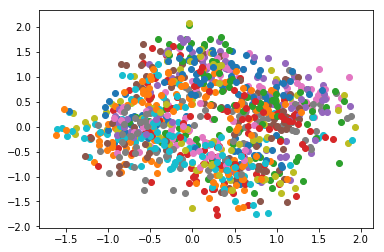

meta_ber: 0.17057291666666669 meta loss: -0.9499459 inner_loss: -1.0480372


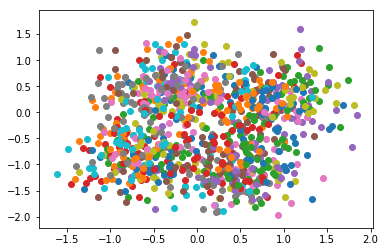

meta_ber: 0.19677734375 meta loss: -1.1699691 inner_loss: -1.1183674


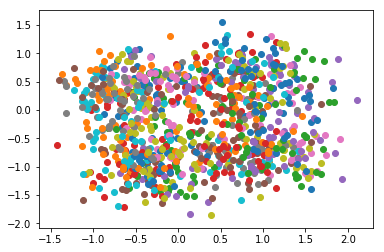

Epoch:  60%|██████    | 301/500 [02:42<01:47,  1.85it/s, Loss=-1.110611, BER=0.186] 

meta_ber: 0.14990234375 meta loss: -1.1421986 inner_loss: -1.1932094


Epoch:  80%|████████  | 400/500 [03:32<00:53,  1.88it/s, Loss=-1.1069044, BER=0.187]

Epoch 400


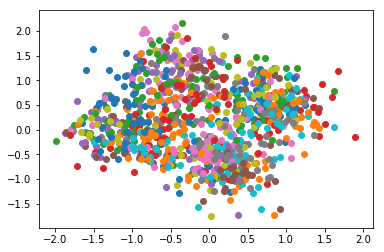

meta_ber: 0.19498697916666666 meta loss: -1.1248894 inner_loss: -1.2160517


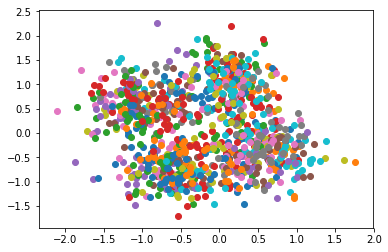

meta_ber: 0.18766276041666666 meta loss: -1.1028271 inner_loss: -1.1619048


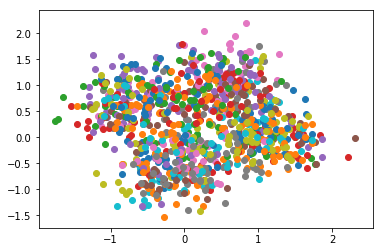

meta_ber: 0.1787109375 meta loss: -1.13102 inner_loss: -1.0685912


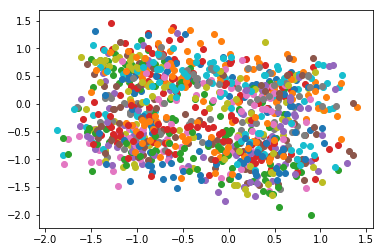

meta_ber: 0.17952473958333334 meta loss: -1.0867407 inner_loss: -0.9740772


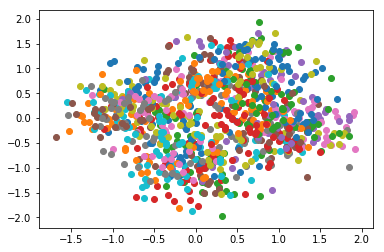

meta_ber: 0.16487630208333331 meta loss: -1.0401506 inner_loss: -1.0730402


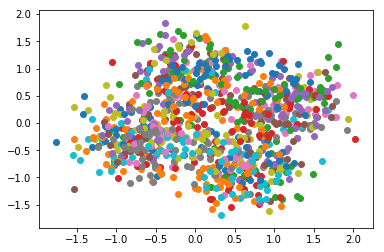

meta_ber: 0.2060546875 meta loss: -0.93828535 inner_loss: -1.1468933


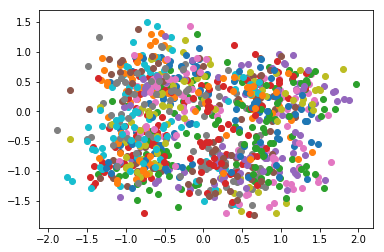

meta_ber: 0.22672526041666666 meta loss: -1.0065786 inner_loss: -1.1186193


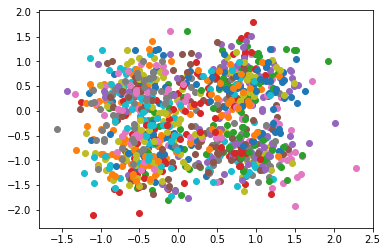

Epoch:  80%|████████  | 401/500 [03:35<00:53,  1.86it/s, Loss=-1.0691476, BER=0.19] 

meta_ber: 0.18505859375 meta loss: -1.1226883 inner_loss: -1.0596483


Epoch: 100%|█████████▉| 499/500 [04:24<00:00,  1.89it/s, Loss=-1.0413444, BER=0.205] 

Epoch 499


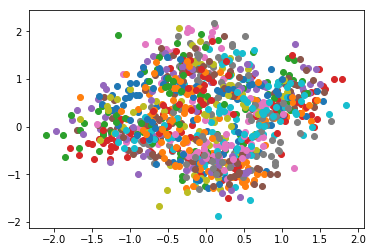

meta_ber: 0.19026692708333331 meta loss: -1.0164084 inner_loss: -1.0717616


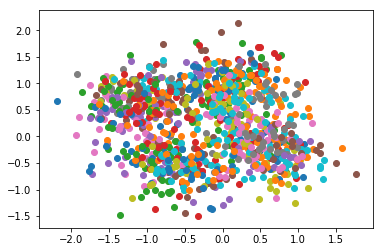

meta_ber: 0.16080729166666669 meta loss: -1.148855 inner_loss: -1.0753504


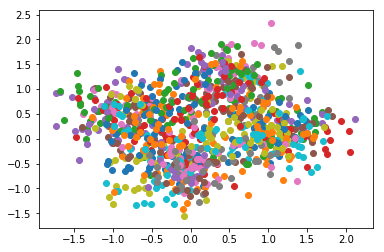

meta_ber: 0.21028645833333331 meta loss: -1.0178493 inner_loss: -0.9692318


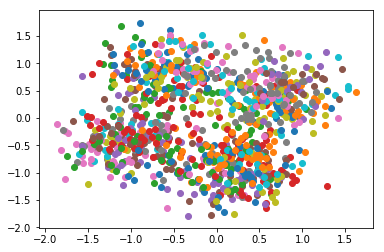

meta_ber: 0.216796875 meta loss: -0.9478247 inner_loss: -1.1926913


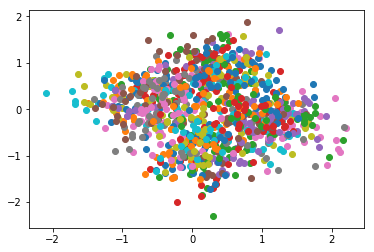

meta_ber: 0.19368489583333331 meta loss: -0.9736586 inner_loss: -0.9673642


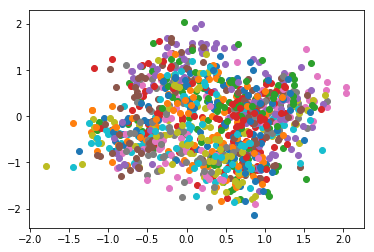

meta_ber: 0.22086588541666666 meta loss: -1.0409825 inner_loss: -0.96271646


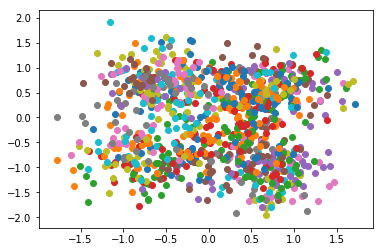

meta_ber: 0.23421223958333331 meta loss: -0.94653744 inner_loss: -1.0172327


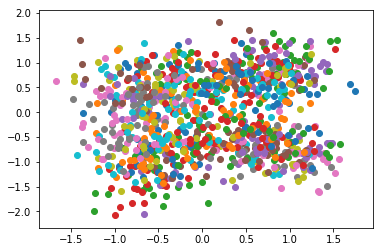

Epoch: 100%|██████████| 500/500 [04:27<00:00,  1.87it/s, Loss=-0.99576867, BER=0.202]

meta_ber: 0.18912760416666666 meta loss: -0.8740332 inner_loss: -1.037629


In [9]:
 
        
mm = MAMLModulatorLossPassing(model=MAMLNeural, SNR_db = 20, stepsize_meta =1e-1, \
                   outer_batch_size = 1024, restrict_energy = 2, inner_steps =15,
                   inner_batch_size= 1024, stepsize_inner = 1e-1, \
                   bits_per_symbol=bps, optimizer='sgd', hidden_layers=[100,100],  std_explore =3e-1, **kwargs)
epochs = 500
stats_every = 100
losses = []
bers = []
with tqdm(range(epochs), desc="Epoch") as pbar:
    for e in pbar:
        if e % stats_every == 0 or e == epochs -1 :
            print("Epoch",e)
            mm.verbose = True
            loss, ber = mm.update_maml(demods)
    #         print(loss, ber)
#             plot_constellation(mm)
        else:
            mm.verbose = False
            loss, ber = mm.update_maml(demods)
        losses.append(loss)
        bers.append(ber)
        pbar.set_postfix({'Loss': loss, 'BER': ber})
    
    
params_maml = mm.model.base.state_dict().copy()


In [10]:
# mm.std_explore = 5e-2
# mm.optimizer = 'adam'
# mm.update_test(demods[0], nshots=100, step_size = 1e-2, batch_size=128)

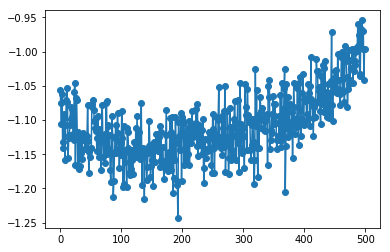

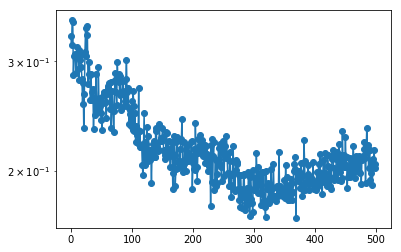

In [11]:
plt.plot(losses, 'o-')
plt.show()

plt.plot(bers, 'o-')
plt.yscale('log')
plt.show()

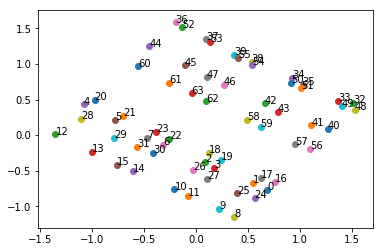

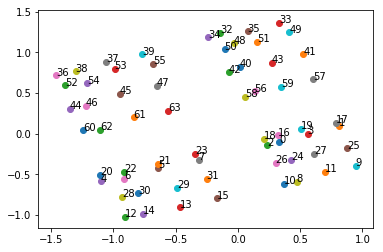

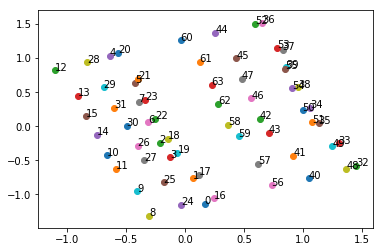

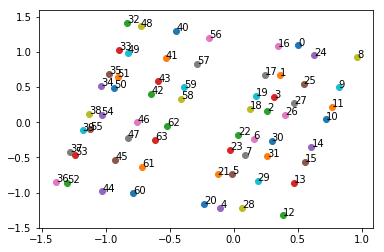

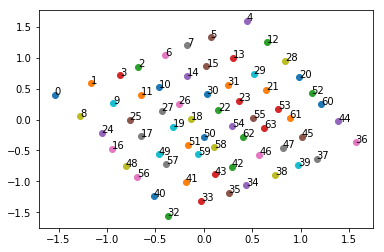

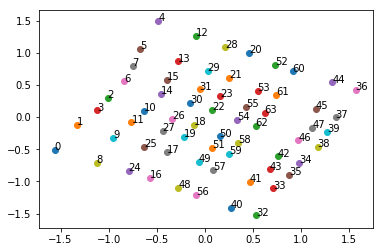

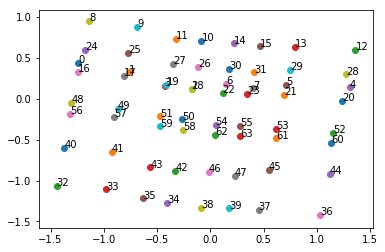

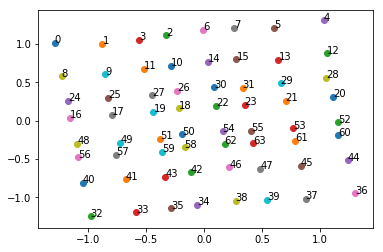

In [18]:
nshots = 200
test_bers = []
mm.std_explore =2e-1
mm.SNR_db = 15
mm.optimizer = 'sgd'
for i in range(len(demods)):
    demod = demods[i]
    mm.model.base.load_state_dict(params_maml)
    taskbers = []
    
    
#     taskbers.append(ber(md.demodulate(channel(tasks[i], snr_dB)), symbols))
  
    taskbers = mm.update_test(demod, nshots=nshots, step_size =2e-1, batch_size=1024)
#     mm.model.base.load_state_dict(params_trained)
#     plot_constellation(mm)
#         taskbers.append(ber(md.demodulate(channel(tasks[i], snr_dB)), symbols))
    test_bers.append(taskbers)
#     break
    
# print(test_bers)
ber_maml = np.array(test_bers).T

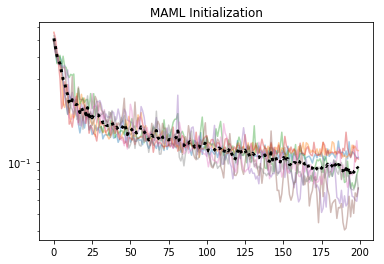

In [13]:
plt.plot(np.arange(nshots), ber_maml, alpha=0.4)

plt.plot(np.mean(ber_maml, axis=1), 'k:', linewidth=3, label="Mean BER Across Tasks")
plt.yscale('log')
# plt.legend()
plt.title("MAML Initialization")
# _ = plt.xticks(np.arange(10) * 5)
plt.show()


In [14]:
mmrnd =  MAMLModulatorLossPassing(model=MAMLNeural, SNR_db = 20, stepsize_meta =1e-1, \
                   outer_batch_size = 128, restrict_energy = 2, inner_steps = 1,\
                   inner_batch_size= 128, stepsize_inner = 2e-1, \
                   bits_per_symbol=bps, std_explore = 1e-1, optimizer='sgd', hidden_layers=[100,100], **kwargs)
params_rand = mmrnd.model.base.state_dict()

Modulator neural initialized with SGD optimizer.


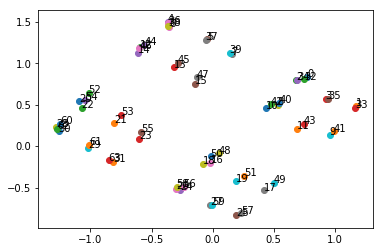

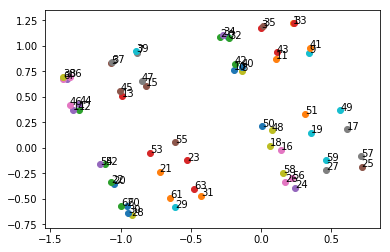

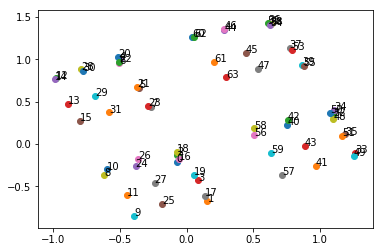

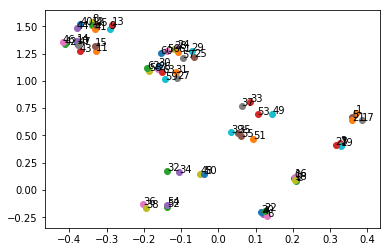

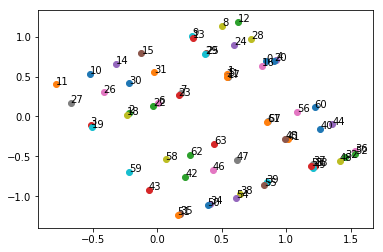

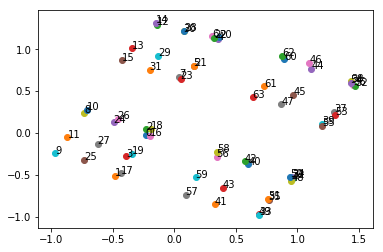

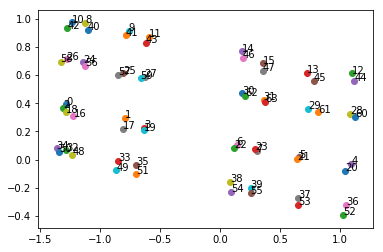

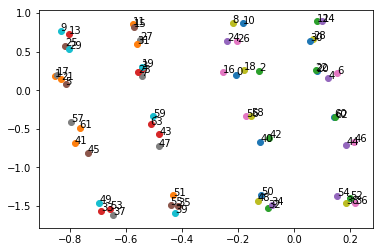

In [15]:

test_bers = []

for i in range(len(demods)):
    demod = demods[i]
    mmrnd.model.base.load_state_dict(params_rand)
    taskbers = []
    
    
#     taskbers.append(ber(md.demodulate(channel(tasks[i], snr_dB)), symbols))
  
    taskbers = mmrnd.update_test(demod, nshots=nshots, step_size = mmrnd.stepsize_inner, batch_size=1024)
        
#         taskbers.append(ber(md.demodulate(channel(tasks[i], snr_dB)), symbols))
    test_bers.append(taskbers)
    
# print(test_bers)
ber_rand = np.array(test_bers).T

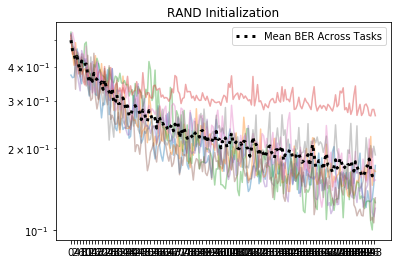

In [16]:
plt.plot(ber_rand, alpha=0.4)
plt.plot(np.mean(ber_rand, axis=1), 'k:', linewidth=3, label="Mean BER Across Tasks")
plt.yscale('log')
plt.legend()
plt.title("RAND Initialization")
_ = plt.xticks(np.arange(0,nshots,2))
